In [6]:
# Note: If you are having trouble loading Spark, try uncommenting the following two lines
#import findspark
#findspark.init()
import pandas as pd
from pandas import DataFrame

import numpy as np
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

# Function loads a food data text file and separates each row into (key, value) pair
# Input: fileName: 'location/of/file.csv'
#        delimiter: 'delimiter string', default='\t'
# Return: [('key', 'header'), ('data', 'header')], RDD <<(key, value), (key, value), ...>>
def loadParkingData(fileName, delimiter=','):
    # Load data values
    csv_data = sc.textFile(fileName)
    split_data = csv_data.map(lambda x: x.split(delimiter))
    
    # Separate header from data
    header = split_data.first()
    data = split_data.filter(lambda x: x!=header)
    
    # Fill missing values with marker values (i.e., np.nan)
    missing_data = data.map(lambda x: [val if val!='' else np.nan for val in x])
    
    # Map the data to (key, value) pairs
    kv_data = missing_data.map(lambda x: ((x[0]), np.array((x[1], x[2]), dtype='float32')))
    kv_header = [(header[0]), (header[1], header[2])] # Match header to kv_data
    
    return kv_header, kv_data


# Load the data in the first file
header, data = loadParkingData('s1.csv')

# Look at the column names and the first row of data
print(header)
print(data.collect()[0])

['Summons Number', ('Violation Code', 'Violation Precinct')]
('1434219940', array([71., 23.], dtype=float32))


In [7]:
# table = data.collect()
# df = DataFrame (table)
# # df = df.transpose()
# df.columns = header
# df.dropna(inplace = True)
# # print (df)

# K Means 

In [8]:
from pyspark.mllib.clustering import KMeans

# Get macronutrient values (i.e., drop keys)
data_values = data.map(lambda x: x[1])

# Cluster food items using k-Means and K=3
K = 3
model = KMeans.train(data_values, K, maxIterations=10, initializationMode='random')

# Look at the location of cluster centers
# HINT: ref [1]
print(model.clusterCenters)

# Show the cluster id of 10 randomply chosen food items
# HINT: ref [2]
cluster_ids = model.predict(data_values)
print(cluster_ids.takeSample(False, 10))

[array([ 44.18737769, 102.91340509]), array([17.63430191, 10.84018427]), array([65.70165157, 37.22802344])]
[2, 2, 1, 0, 1, 2, 1, 2, 2, 1]


# Elbow Method to find K

In [9]:
# Compute the Within Set Sum of Squared Errors
# HINT: ref [3]
print(model.computeCost(data_values))

3829065.7605710775


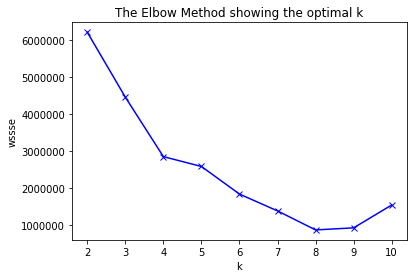

In [20]:
from matplotlib import pyplot as plt

# Train k-Means with k values in [2,10] and calculate WSSSE for each clustering
K = []
w = []

for k in range(2,11):
    K.append(k)
    model = KMeans.train(data_values, k, maxIterations=10, initializationMode='random')
    wssse = model.computeCost(data_values)
    w.append(wssse)
    
plt.plot(K, w, 'xb-')
    
plt.xlabel('k')
plt.ylabel('wssse')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Plot the WSSSE for different values of k


# Plot Clusters

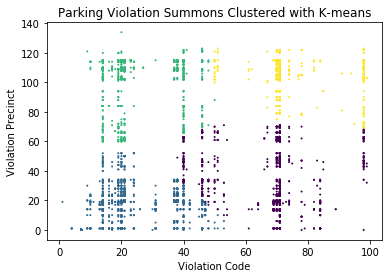

<Figure size 432x288 with 0 Axes>

In [21]:
# Function plots 2D food clusters
# Input: data: RDD <<(carb1, fat1), (carb2, fat2), (carb3, fat3), ...>>
#        cluster_ids: list of cluster ID integers [0, 0, 1, 0, 2, 5, 3, 3, ...]
# Return: None (shows a plot)

def plotFoodClusters(data, cluster_ids):
    # Plot the clusters with a scatter plot
    # HINT: ref[4]
    data = np.array(data.collect())
    plt.scatter(data[:,0], data[:,1], c=cluster_ids, s=1)
    # Define axis labels and plot title
    plt.xlabel('Violation Code')
    plt.ylabel('Violation Precinct')
    plt.title('Parking Violation Summons Clustered with K-means')
    plt.show()
    plt.clf()

# Function clusters food items and plots clusters
# Input: data: RDD <<(carb1, fat1), (carb2, fat2), (carb3, fat3), ...>>
#        K: integer value for number of clusters
# Return: None (shows a plot)

def clusterAndPlotData(data, K):
    # Cluster food items using kMeans and input K value
    data = data.map(lambda x: x[1])
    model = KMeans.train(data, K, maxIterations=10, initializationMode='random')
    cluster_ids = model.predict(data)

    # Get the cluster ID for each food item in the dataset.  
    # Cluster ID values are used to show clusters with color in plots
    # Plot food clusters
    plotFoodClusters (data, cluster_ids.collect())

    
# Define the optimal K value you found above.  It will be used for the remainder of the assignment!
K = 4

# Cluster and plot food items from ./data/data-1.csv
clusterAndPlotData(data, K)